[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/anonym-gm/asplenia_EHR_embedding/blob/main/CV_emb_lgbm.ipynb)

## Libraries

In [307]:
import math
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.simplefilter(action='ignore')
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import (
    matthews_corrcoef, confusion_matrix, accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score
)
from tqdm.notebook import tqdm

## Dowload source files

In [308]:
!wget https://raw.githubusercontent.com/anonym-gm/asplenia_EHR_embedding/main/spleen_dataset.json
!wget https://raw.githubusercontent.com/anonym-gm/asplenia_EHR_embedding/main/targets.csv
!wget https://raw.githubusercontent.com/anonym-gm/asplenia_EHR_embedding/main/static_vars.txt
!wget https://raw.githubusercontent.com/anonym-gm/asplenia_EHR_embedding/main/derived_vars.txt

zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget


## Setting parameters

In [338]:
class Settings:
    pathologies = "2,3"   # 0 = CHA; 1 = SCD; 2 = TDT; 3 = NTDT; 2,3 = TDT+NTDT; 0,1,2,3,4,5,6,7,8 = ALL
    input_file = "spleen_dataset.json"
    static_vars_file = "static_vars.txt"
    derived_vars_file = "derived_vars.txt"
    target_file = "targets.csv"
    splen = "1"
    min_events = 3
    display = True
    use_vars = "static,lstm"

args = Settings()

## Select variables 

In [333]:
sel_columns = pd.read_csv(args.static_vars_file, header=None, index_col=0).index.tolist() + \
            pd.read_csv(args.derived_vars_file, header=None, index_col=0).index.tolist()

## Load the dataset

In [339]:
sequences = {}
with open(args.input_file) as f:
    synt_list = json.load(f)
    for elem in tqdm(synt_list, desc="Extracting events"):
        sequences[elem['id']] = [(elem['events'][i]['event'], elem['events'][i]['date']) for i in range(len(elem['events']))]
    sequences
    Xorig = pd.read_json(args.input_file).drop(columns=['events'])
    Xstatic = Xorig[sel_columns]

    print(f"X_static shape: {Xstatic.shape}")
    print(f"ATTRIBUTES: {sorted(Xstatic.columns)}")

Extracting events:   0%|          | 0/1789 [00:00<?, ?it/s]

X_static shape: (1789, 29)
ATTRIBUTES: ['age_group', 'age_vax_flu', 'age_vax_hib', 'age_vax_meningo', 'age_vax_pneumo', 'base_pathology_area', 'bmi', 'dyslipidemia', 'gender', 'genotype_alpha1', 'genotype_alpha2', 'genotype_beta1', 'genotype_beta2', 'hbf', 'heparin', 'is_splenectomized?', 'pre_splenectomy_vax_flu', 'pre_splenectomy_vax_hib', 'pre_splenectomy_vax_meningo', 'pre_splenectomy_vax_pneumo', 'primary_pathology', 'qt_vax_post_splenectomy', 'qt_vax_pre_splenectomy', 'qt_vax_totali', 'smoking', 'splenectomy_indication', 'splenectomy_method', 'splenectomy_response', 'tsh']


## Methods

### LSTM

In [335]:
# Dataset Builder
class TextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

# LSTM embedding model
class LSTMEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pooling=False):
        super().__init__()
        self.pooling = pooling
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=False)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hn, cn) = self.lstm(embedded)
        if self.pooling:
            return output.mean(dim=1)
        else:
            return hn.squeeze(0)

    def train_model(self, dataloader, num_epochs=10, enable_plot=False, disable=False):

        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        criterion = torch.nn.MSELoss()

        loss_history = []

        self.train()
        pbar = tqdm(range(num_epochs), disable=disable, desc=f"Embedding:")
        for epoch in pbar:
            total_loss = 0
            for batch in dataloader:
                optimizer.zero_grad()
                batch = batch.long()
                output = self(batch)

                target = torch.zeros_like(output)
                loss = criterion(output, target)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            pbar.set_description(f"Embedding: Loss {avg_loss:.4f}")
            loss_history.append(avg_loss)

            if enable_plot:
                clear_output(wait=True)
                plt.plot(loss_history, label="Loss")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.title("Training Loss Over Time")
                plt.legend()
                plt.grid()
                plt.show()

def similarity_matrix(events, attributes, targets, emb1, emb2):
    attributes = [a.lower() for a in attributes]
    targets = [t.lower() for t in targets]
    zero_data = np.ones((len(events), len(attributes)))
    X_df = pd.DataFrame(zero_data, columns=attributes, index=events.keys())

    Wmul = emb1.T@emb2
    for id, dcount in tqdm(events.items(), desc="Risk calculating"):
        for concept in dcount.keys():
            concept_l = concept.lower()
            if concept_l in attributes:
                X_df.loc[id, concept_l] += dcount[concept] * np.array([math.exp(Wmul[concept_l][disease]) for disease in targets]).mean()
    return X_df

## Selection of patients by pathology

In [340]:
# Patient selection by pathology
def select_patients(df, event_counts, pathologies, splen_flags=[0,1], min_ev_count=3):
    filtered_events = {}
    selected_patient_ids = df[
        df['base_pathology_area'].isin(pathologies) &
        df['is_splenectomized?'].isin(splen_flags)
    ].index.tolist()

    filtered_events = {
        int(key): value for key, value in event_counts.items()
        if int(key) in selected_patient_ids and len(value.keys()) > min_ev_count
    }

    selected_patient_ids = np.array(list(filtered_events.keys()))
    return selected_patient_ids, filtered_events


# === Vocabulary === 
vocab = set()
for patient_events in sequences.values():
    for event,_ in patient_events:
        vocab.update([event] if isinstance(event, str) else event)
word_to_idx = {word: idx for idx, word in enumerate(sorted(vocab))}
idx_to_word = {i: word for word, i in word_to_idx.items()}
print(f"VOCABOLARY SIZE: {len(vocab)}")

# Index sequences and padding (for embeddings)
indexed_sentences = [[word_to_idx[word] if word in word_to_idx else 0
                      for _, word in patient_events if word in word_to_idx]
                     for patient_events in sequences.values()]
padded_sentences = pad_sequence([torch.tensor(s) for s in indexed_sentences], batch_first=True)

# Target infection
targets = pd.read_csv(args.target_file)['targets'].to_list()
embed_attributes = [w for w in sorted(vocab) if w not in targets]

# === Patient selection ===
pathologies = []
for p in args.pathologies.split(','):
    if int(p.strip()) in Xstatic['base_pathology_area'].unique():
        pathologies.append(int(p.strip()))
    else:
        raise Exception(f"Primary pathology {p} not in dataset!")
splen_flags = list(map(int, args.splen.split(',')))
min_ev_count = args.min_events

selected_patient_ids, events = select_patients(Xstatic, event_counts, pathologies, splen_flags=splen_flags, min_ev_count=min_ev_count)
print(f"# [{args.pathologies}] PATIENTS: {len(selected_patient_ids)}")

VOCABOLARY SIZE: 107
# [2,3] PATIENTS: 422


## Cross validation + embedding

Targets:   0%|          | 0/422 [00:00<?, ?it/s]

(422, 1)


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

(array([0., 1.]), array([306, 116])) count: 0

🚀 Inizio cross-validation...



Embedding::   0%|          | 0/10 [00:00<?, ?it/s]

Risk calculating:   0%|          | 0/422 [00:00<?, ?it/s]

X_static shape (337, 29) (85, 29) X_lstm shape (337, 75) (85, 75) Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's MCC: 0.622312


Embedding::   0%|          | 0/10 [00:00<?, ?it/s]

Risk calculating:   0%|          | 0/422 [00:00<?, ?it/s]

X_static shape (337, 29) (85, 29) X_lstm shape (337, 75) (85, 75) Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's MCC: 0.582142


Embedding::   0%|          | 0/10 [00:00<?, ?it/s]

Risk calculating:   0%|          | 0/422 [00:00<?, ?it/s]

X_static shape (338, 29) (84, 29) X_lstm shape (338, 75) (84, 75) Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's MCC: 0.596975


Embedding::   0%|          | 0/10 [00:00<?, ?it/s]

Risk calculating:   0%|          | 0/422 [00:00<?, ?it/s]

X_static shape (338, 29) (84, 29) X_lstm shape (338, 75) (84, 75) Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's MCC: 0.394431


Embedding::   0%|          | 0/10 [00:00<?, ?it/s]

Risk calculating:   0%|          | 0/422 [00:00<?, ?it/s]

X_static shape (338, 29) (84, 29) X_lstm shape (338, 75) (84, 75) Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's MCC: 0.521026

📊 Risultati medi su 5 fold:
📈 AUC:      0.7322 ± 0.0683
🧪 F1-score: 0.6076 ± 0.1115
⚖️ Precision:0.8166 ± 0.1156
🔁 Recall:   0.5181 ± 0.1553
🧮 MCC:      0.5434 ± 0.0816
🎯 Accuracy: 0.8269 ± 0.0262

🧩 Confusion Matrix finale (aggregata):
[[289  17]
 [ 56  60]]


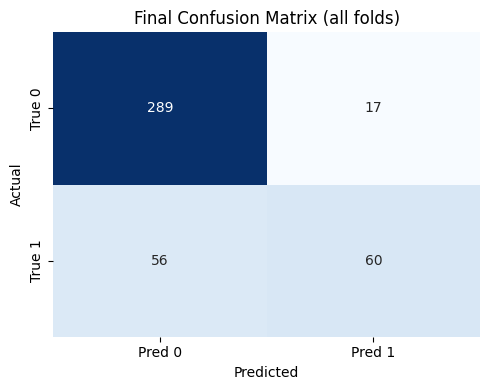

In [343]:
# Embedding parameters
num_epochs = 10  # 10
vocab_size = len(vocab)
embedding_dim = 64  # 16
hidden_dim = 128
batch_size = 32

# LGBM parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'None',
    'verbosity': -3,
    'is_unbalance': True
}

def mcc_eval(y_pred, dataset):
    y_true = dataset.get_label()
    y_pred_labels = (y_pred > 0.5).astype(int)
    mcc = matthews_corrcoef(y_true, y_pred_labels)
    return 'MCC', mcc, True

mcc_scores = []
acc_scores = []
rocauc_scores = []
prec_scores = []
recall_scores = []
f1_scores = []

y_valid_all = []
y_pred_all = []

from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
zero_data = np.zeros((len(events.keys()),))
y_df = pd.DataFrame(zero_data, columns=['target']).set_index(pd.Series([e for e in list(events.keys())]))
cnt = 0
for id, dcount in tqdm(events.items(), desc="Targets"):
    if len(set([e.lower() for e in dcount.keys()]).intersection(set(targets))) > 0:  # if there's at least one occurrence of the target set 1
        y_df.loc[id, 'target'] = 1
y = y_df.values.astype(np.float32).ravel()
print(y_df.shape)
cvfolding = tqdm(skf.split(selected_patient_ids, y), total=n_splits, desc="Folds")
print(np.unique(y_df.values, return_counts=True), f"count: {cnt}")

use_vars = []
for v in args.use_vars.split(","):
    if v.strip() in ["static", "binary", "lstm", "dummy"]:
        use_vars += [v.strip()]
    else:
        raise Exception("Wrong method in paramters")

print("\n🚀 Inizio cross-validation...\n")
for fold, (t_idx, v_idx) in enumerate(cvfolding):

    train_idx, valid_idx = selected_patient_ids[t_idx], selected_patient_ids[v_idx]
    Xtrains = dict(zip(use_vars, [pd.DataFrame(index=train_idx)]* len(use_vars)))
    Xtests = dict(zip(use_vars, [pd.DataFrame(index=valid_idx)]* len(use_vars)))
    if "lstm" in use_vars:
        train_sentences = [[word_to_idx[word] for word,_ in sequences[id]] for id in train_idx]
        padded_train = pad_sequence([torch.tensor(s) for s in train_sentences], batch_first=True)
        # Dataloaders
        embedding_dataset = TextDataset(padded_train)
        dataloader = DataLoader(embedding_dataset, batch_size=32, shuffle=True)
        # Init + train LSTM model
        embmodel = LSTMEmbeddingModel(len(word_to_idx), embed_dim=64, hidden_dim=128, pooling=False)
        embmodel.train_model(dataloader, enable_plot=False, disable=False)
        word_indices = [idx for word, idx in word_to_idx.items() if word != "<PAD>"]
        word_tensors = torch.tensor(word_indices).unsqueeze(1)  # Shape (num_words, 1)
        embedding = embmodel(word_tensors).detach().numpy()
        W = pd.DataFrame(embedding.T, columns=[w.lower() for w in vocab])
        X_df = similarity_matrix(events, embed_attributes, list(set(targets).intersection(vocab)), W, W)
        Xtrains['lstm'] = X_df.loc[train_idx]
        Xtests['lstm'] = X_df.loc[valid_idx]
    if "dome" in use_vars:
        raise Exception("DOME not included in demo...")
    if "static" in use_vars:
        Xtrains['static'] = Xstatic.loc[train_idx]
        Xtests['static'] = Xstatic.loc[valid_idx]
    if "binary" in use_vars:
        raise Exception("Binary not included in demo...")
    if "dummy" in use_vars:
        Xtrains['dummy'] = pd.DataFrame(np.random.rand(len(train_idx), 128), index=train_idx)
        Xtests['dummy'] = pd.DataFrame(np.random.rand(len(valid_idx), 128), index=valid_idx)
    for v in use_vars:
        print(f"X_{v} shape {Xtrains[v].shape} {Xtests[v].shape}", end=' ')
    X_df_train = pd.concat(list(Xtrains.values()), axis=1)
    X_df_tests = pd.concat(list(Xtests.values()), axis=1)
    X_train, X_valid = X_df_train.values.astype(np.float32), X_df_tests.values.astype(np.float32)
    y_train, y_valid = y_df.loc[train_idx].values.astype(np.float32).ravel(), y_df.loc[valid_idx].values.astype(np.float32).ravel()
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)

    model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[valid_data],
        feval=mcc_eval,
        callbacks=[
            lgb.early_stopping(50),
            lgb.log_evaluation(0)
        ]
    )

    y_pred = model.predict(X_valid)
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Metriche fold
    mcc = matthews_corrcoef(y_valid, y_pred_labels)
    acc = accuracy_score(y_valid, y_pred_labels)
    rocauc = roc_auc_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred_labels)
    recall = recall_score(y_valid, y_pred_labels)
    f1 = f1_score(y_valid, y_pred_labels)

    # Salva
    mcc_scores.append(mcc)
    acc_scores.append(acc)
    rocauc_scores.append(rocauc)
    prec_scores.append(prec)
    recall_scores.append(recall)
    f1_scores.append(f1)
    y_valid_all.extend(y_valid)
    y_pred_all.extend(y_pred_labels)

    cvfolding.set_postfix({
        "Fold": fold + 1,
        "MCC": f"{mcc:.4f}",
        "AUC": f"{rocauc:.4f}",
        "Acc": f"{acc:.4f}",
        "F1": f"{f1:.4f}"
    })

# Final confusion matrix
cm_final = confusion_matrix(y_valid_all, y_pred_all)

print(f"\n📊 Risultati medi su {n_splits} fold:")
print(f"📈 AUC:      {np.mean(rocauc_scores):.4f} ± {np.std(rocauc_scores):.4f}")
print(f"🧪 F1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"⚖️ Precision:{np.mean(prec_scores):.4f} ± {np.std(prec_scores):.4f}")
print(f"🔁 Recall:   {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"🧮 MCC:      {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}")
print(f"🎯 Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")

print(f"\n🧩 Confusion Matrix finale (aggregata):\n{cm_final}")

if args.display:
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title('Final Confusion Matrix (all folds)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()